# Deep Mirror ML Engineer Task

We train three types of models on a benchmark ADME dataset taken from TDC and compare performances with a common metric. Results given are summarised in the a separate pdf document for presentation to the sales team.

Datasets and data processors can be directly borrowed from the TDC python support. To deal with graph data we will be using pytorch-geometric. After installing dependencies, please remember to restart the runtime if running on google colab.

In [1]:
!pip install PyTDC==0.3.7
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 105 kB 9.2 MB/s 
     |████████████████████████████████| 29.3 MB 12.3 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.7-py3-none-any.whl size=130431 sha256=f768e76420c9d89730663978d5c0152f474f5caa1c39680a6787e5de8de167e3
  Stored in directory: /root/.cache/pip/wheels/0d/f0/c0/c916d1612b7c8b0fe58db8b03ef009aa5fa8e18a9266f1ba02
Successfully built PyTDC
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cpu.html
     |████████████████████████████████| 539 kB 19.6 MB/s 
     |████████████████████████████████| 491 kB 54.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
     |████████████████████████████████| 704 kB 20.6 MB/s 
     |████████████████████████████████| 202 kB 47.7 MB/s 
     |████████████████████████████████| 564 kB 16.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 28.9 MB/s 


## Choice of Dataset

The Choice of dataset made was CYP P450 2C19 Inhibition, Veith et al. Dataset Description given by website: The CYP P450 genes are essential in the breakdown (metabolism) of various molecules and chemicals within cells. A drug that can inhibit these enzymes would mean poor metabolism to this drug and other drugs, which could lead to drug-drug interactions and adverse effects. Specifically, the CYP2C19 gene provides instructions for making an enzyme called the endoplasmic reticulum, which is involved in protein processing and transport.

The reason for this choice had no significant reason to do with the context of the dataset but more so to do with its structure. It is labelled as a binary classifcation task as well as consisting of a balanced dataset - meaning relatively speaking it is an easy dataset to deal with.

In [1]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP2C19_Veith')
split = data.get_split(seed=12)

Found local copy...
Loading...
Done!


In [2]:
# obtaining splits for training, validating and testing
train_split = split['train']
val_split = split['valid']
test_split = split['test']

The dataset has already been nicely sorted for us in a pandas dataframe with important columns being 'Drug' and 'Y'. 

In [3]:
train_split.head()

,Drug_ID,Drug,Y
0,6602638.0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1.Cl,0
1,644675.0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1
2,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1
3,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1
4,645063.0,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0


In [20]:
sum(train_split.Y) + sum(val_split.Y) + sum(test_split.Y)

5819

In [22]:
5819/12665

0.4594551914725622

In [21]:
len(data)

12665

As we see, the dataset is pretty balanced in terms of positive and negative instances.

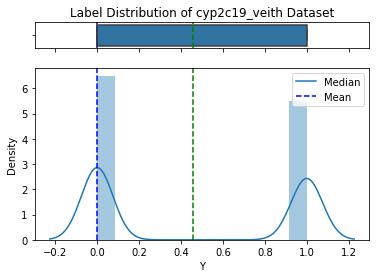

In [4]:
data.label_distribution()

The 'Drug' column consists of SMILES strings which may be readily converted into pytorch-geometric Data objects by TDC's built-in 'MolConvert' class. This gives us an easy way of creating out Dataloaders for training and evaluating.

In [5]:
import torch
from tdc.chem_utils import MolConvert

converter = MolConvert(src = 'SMILES', dst = 'PyG')

# creating training object lists
training_list = []
for index, row in train_split.iterrows():
    obj = converter(row['Drug'])
    label = torch.tensor([row['Y']])
    obj.y = label
    training_list.append(obj)

In [6]:
# validation set
validation_list = []

for index, row in val_split.iterrows():
    obj = converter(row['Drug'])
    label = torch.tensor([row['Y']])
    obj.y = label
    validation_list.append(obj)

# validation set
test_list = []

for index, row in test_split.iterrows():
    obj = converter(row['Drug'])
    label = torch.tensor([row['Y']])
    obj.y = label
    test_list.append(obj)

In [7]:
print('length of training set', len(training_list))
print('length of validation set', len(validation_list))
print('length of test set', len(test_list))

length of training set 8866
length of validation set 1266
length of test set 2533


We note that for each atom of each molecule, there are 39 node features:

In [8]:
training_list[0].x.shape

torch.Size([22, 39])

In [9]:
from torch_geometric.loader import DataLoader
from torch_geometric.seed import seed_everything

# creating the dataloaders. For reproducability, use a seed
seed_everything(12)

train_loader = DataLoader(training_list, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_list, batch_size=32, shuffle=True)
test_loader = DataLoader(test_list, batch_size=32, shuffle=True)

We start benchmarking results, and go through the three types of models.

## Graph Neural Network Model

In [10]:
%cd /content/drive/MyDrive/DeepMirror/

/content/drive/MyDrive/DeepMirror


We train under Binary Cross Entropy loss since we are undertaking a binary classification task. However, for a more intuitive comparison figure, we use the Average Precision (AUPRC) metric for presentation of results, which is more explainable to the human.

Our GNN is a simple GNN with a few graphical layers followed by 3 linear layers for prediction. The graphical layers are GCNConv layers which basic graph convolutional operator.

Not too much emphasis was placed on the optimisation of such graphical architectures, as I believed the purpose of this task was more for demonstration/proof of concepts in each of the three different models.

In [11]:
from models import GNN
from training import train_model

model = GNN()
train_losses, val_losses, auprc_losses = train_model(model, train_loader, val_loader, epochs=100, lr=0.0001)

epoch: 5, training_loss: 39.328338994396674, val_loss: 39.44261947870255, val_AUPRC: 0.6573011934757232
epoch: 10, training_loss: 37.63056343665226, val_loss: 38.23155435323715, val_AUPRC: 0.6878134936094285
epoch: 15, training_loss: 35.6155909402765, val_loss: 36.05532227158547, val_AUPRC: 0.7471251308917999
epoch: 20, training_loss: 33.93616902227882, val_loss: 34.904756063222884, val_AUPRC: 0.7714758276939392
epoch: 25, training_loss: 33.22162396787739, val_loss: 34.2785990446806, val_AUPRC: 0.7792018443346024
epoch: 30, training_loss: 33.1169743173414, val_loss: 34.19750071167946, val_AUPRC: 0.7829824477434159
epoch: 35, training_loss: 32.74891574948812, val_loss: 34.173047894239424, val_AUPRC: 0.7880938023328781
epoch: 40, training_loss: 32.173967759386244, val_loss: 33.577547293901446, val_AUPRC: 0.7984365463256836
epoch: 45, training_loss: 32.23331579630324, val_loss: 33.957903516292575, val_AUPRC: 0.8017524689435959
epoch: 50, training_loss: 31.79715697799655, val_loss: 33.0598

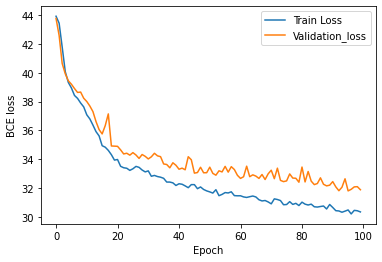

In [14]:
import matplotlib.pyplot as plt
epochs = range(len(train_losses))
plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend(['Train Loss', 'Validation_loss'])

Text(0, 0.5, 'AUPRC loss')

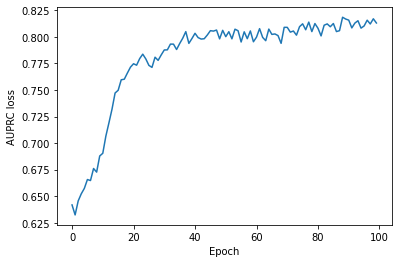

In [15]:
plt.plot(epochs, auprc_losses)
plt.xlabel("Epoch")
plt.ylabel("AUPRC loss")

Finally we test our model on the unseen test set.

In [16]:
from training import val_data_epoch
test_loss, test_auprc_loss = val_data_epoch(model, test_loader)
print('test loss of GNN:', test_loss)
print('AUPRC loss of GNN:', test_auprc_loss)

test loss of GNN: 30.148818914592265
AUPRC loss of GNN: 0.8258148908615113


## Decision Tree Model

The classical decision tree for classification is a supervised, fundamentally separation algorithm which assigns each section of the input space to a class which minises a designated loss function. The issue with such a classical method is that which graphical data (such as molecules) it is hard to map variable input vectors to a fixed space.

GNNs dealt with this in the form of message passing (to deal with connectivity), aggregation and pool functions. However we are not allowed this in decision trees. My decision in the end to avoid all learning/differentiable methods for such a aggregation function was really to demonstrate that decision trees (at least not on their own) are not appropriate for this task.

We use sci-kit learn's decision tree class to perform the classification. I chose to use a mean pooling function to reduce all node features to a global feature for each molecule, and ignored edge connectivity.

The reason for ignoring edge connectivity was because of the difficulty in its encoding. A molecule has varying amounts of edges, thus the only encoding method possible would be an adjacency matrix. However adjacency matrices are not permutation invariant (they certainly do not emulate a vector space) and also are in general sparse, thus cause decision trees to have over-fitting issues/lack of sample.

In [17]:
import numpy as np

# creating the covariate matrix for fitting.
# we do this for the training and test data
X_dat = np.zeros((len(training_list), 39))
labels = []
for i, dat in enumerate(training_list):
    # we aggregate across all atoms in the molecule for dimensional consistency.
    x = torch.mean(dat.x, dim=0).numpy()
    y = dat.y
    X_dat[i] = x
    labels.append(y[0])


test_dat = np.zeros((len(test_list), 39))
test_labels = []
for i, dat in enumerate(test_list):
    x = torch.mean(dat.x, dim=0).numpy()
    y = dat.y
    test_dat[i] = x
    test_labels.append(y[0])

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_dat, labels)

DecisionTreeClassifier()

[Text(0.4850974320689499, 0.9838709677419355, 'X[38] <= 0.431\ngini = 0.496\nsamples = 8866\nvalue = [4835, 4031]'),
 Text(0.12947310243663498, 0.9516129032258065, 'X[34] <= 0.976\ngini = 0.385\nsamples = 3139\nvalue = [2322, 817]'),
 Text(0.05642730219276305, 0.9193548387096774, 'X[38] <= 0.376\ngini = 0.187\nsamples = 1310\nvalue = [1173, 137]'),
 Text(0.03377339711522428, 0.8870967741935484, 'X[0] <= 0.69\ngini = 0.15\nsamples = 1098\nvalue = [1008, 90]'),
 Text(0.010421877605469402, 0.8548387096774194, 'X[20] <= 0.02\ngini = 0.058\nsamples = 370\nvalue = [359, 11]'),
 Text(0.008754377188594297, 0.8225806451612904, 'X[7] <= 0.08\ngini = 0.053\nsamples = 368\nvalue = [358, 10]'),
 Text(0.0074203768550942135, 0.7903225806451613, 'X[24] <= 0.33\ngini = 0.044\nsamples = 359\nvalue = [351, 8]'),
 Text(0.006753376688344172, 0.7580645161290323, 'gini = 0.0\nsamples = 210\nvalue = [210, 0]'),
 Text(0.008087377021844255, 0.7580645161290323, 'X[25] <= 0.433\ngini = 0.102\nsamples = 149\nvalue

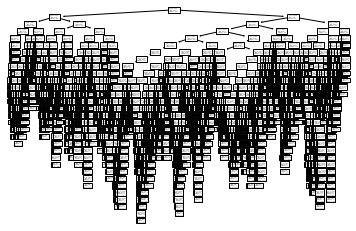

In [19]:
# we may plot the decision tree if we like. The advantage of decision trees is that they are explainable.
# For such a large dataset, this may not be sensible.
tree.plot_tree(clf)

We now test on the test data.

In [21]:
from torchmetrics import AveragePrecision
crit = torch.nn.BCELoss()
alt_crit = AveragePrecision(task="binary")

outputs = clf.predict(test_dat)
print('BCE loss', crit(torch.from_numpy(outputs).float(), torch.tensor(test_labels).float()))
print('AUPRC loss', alt_crit(torch.from_numpy(outputs).float(), torch.tensor(test_labels).float()))


BCE loss tensor(33.1623)
AUPRC loss tensor(0.5805)


As expected, performed significantly worse.

## Graph Transformer

Graph transformers (what I interpreted as a transformer model) are a form of GNN which implements transformer architecture to the graphical layers of the model. Transformers have been used successfully in the NLP environment, which its emphasis on Attention-based layers which give certain weighting to each word of a sentence. This lends itself smoothly to graphs, where we may choose to implement attention masks onto the graphs we deal with too.

Again for the sake of simplicity and concept demonstration, we use the exact same model as we did in the GNN, but this time replace the GCNConv layers with TransformerConv layers.

In [11]:
from models import TransformerNet
from training import train_model
transformer = TransformerNet()
train_losses, val_losses, auprc_losses = train_model(transformer, train_loader, val_loader, epochs=50, lr=0.0001)

epoch: 5, training_loss: 19.212601780033797, val_loss: 19.345852148532867, val_AUPRC: 0.711090224981308
epoch: 10, training_loss: 18.295339888377157, val_loss: 18.412288820743562, val_AUPRC: 0.744139564037323
epoch: 15, training_loss: 17.34660413325262, val_loss: 17.33292859494686, val_AUPRC: 0.7805059880018235
epoch: 20, training_loss: 16.328273334949138, val_loss: 16.950899904966356, val_AUPRC: 0.8095509931445122
epoch: 25, training_loss: 15.807315001813627, val_loss: 16.287682217359542, val_AUPRC: 0.8187234386801719
epoch: 30, training_loss: 15.509164831621185, val_loss: 16.460654777288436, val_AUPRC: 0.8213659420609474
epoch: 35, training_loss: 15.2891038171679, val_loss: 15.452400028705597, val_AUPRC: 0.8295243009924889
epoch: 40, training_loss: 15.026474087143974, val_loss: 15.18999175131321, val_AUPRC: 0.8424325540661812
epoch: 45, training_loss: 14.846353903520022, val_loss: 15.170052734017371, val_AUPRC: 0.8344717100262642
epoch: 50, training_loss: 14.71506685415189, val_loss:

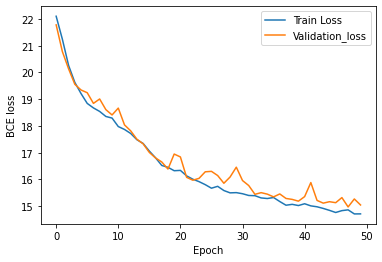

In [14]:
import matplotlib.pyplot as plt
epochs = range(len(train_losses))
plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.legend(['Train Loss', 'Validation_loss'])

Text(0, 0.5, 'AUPRC loss')

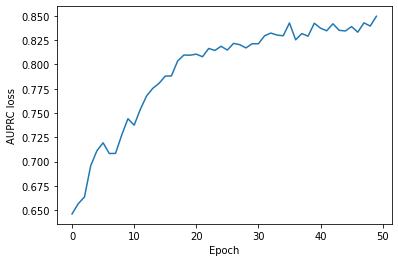

In [15]:
plt.plot(epochs, auprc_losses)
plt.xlabel("Epoch")
plt.ylabel("AUPRC loss")

Finally we test on the test data.

In [17]:
from training import val_data_epoch
test_loss, test_auprc_loss = val_data_epoch(transformer, test_loader)
print('test loss of GNN:', test_loss)
print('AUPRC loss of GNN:', test_auprc_loss)

test loss of GNN: 15.268518921732902
AUPRC loss of GNN: 0.8366920739412308


Which has made a small improvement on the previous GNN.